## This notebook is to create fake maps for testing of the code
We will make both well-behaved data and not so well-behaved data.

In [1]:
from pdrtpy.measurement import Measurement
from pdrtpy.modelset import ModelSet
from pdrtpy.plot.lineratioplot import LineRatioPlot
from pdrtpy import version
import pdrtpy.pdrutils as utils
from pdrtpy.tool.lineratiofit import LineRatioFit
from astropy.nddata import StdDevUncertainty
import numpy as np
from astropy.nddata import CCDData
from copy import deepcopy
from astropy.wcs import WCS
from astropy.io import fits
import astropy.units as u
import math
from astropy.modeling.models import Gaussian2D
import matplotlib.pyplot as plt

/home/mpound/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1161: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


### Make FITS files with 2D gaussians

In [2]:
class Blob():
    def __init__(self,name="TEST",amp = 5E-3,xc = 50, yc = 50, sigmax = 7, 
                 sigmay = 5, pa = 0, error = 0.1, naxis1=100,naxis2=100, 
                 unit ="erg s-1 cm-2 sr-1" ):
        self._pa = pa*u.degree # measured north through towards east, in degrees.
        self._blob = Gaussian2D(amplitude=amp, x_mean=xc, y_mean=yc,
                                x_stddev=sigmax, y_stddev=sigmay,theta=-self._pa.to('radian'))
        self._name = name
        self._unit = u.Unit(unit)
        self._data = self._blob(*np.mgrid[0:naxis1, 0:naxis2])
        self._error = amp * error * (np.random.rand(naxis1,naxis2)-0.5)
        self._wcs = None
        self._header = None
        self._template_file = None
        self._hdu = None
        
    @property
    def final(self):
        return self._data + self._error
    
    @property
    def data(self):
        return self._data
    
    @property
    def error(self):
        return self._error
    
    @property
    def wcs(self):
        return self._wcs
    @property
    def header(self):
        return self._header
    
    def set_FITS_template(self,filename,delete_history=True):
        self._template_file = filename
        self._hdu = fits.open(filename)
        if delete_history and 'HISTORY' in self._hdu[0].header:
            del self._hdu[0].header['HISTORY']
        self._hdu[0].header['HISTORY'] = self._name + ' fake data for testing'
        self._hdu[0].header['BUNIT'] = self._unit.to_string()
        self._hdu[0].header["NAXIS1"]=self._data.shape[0]
        self._hdu[0].header["NAXIS2"]=self._data.shape[1]
        self._hdu[0].header["ORIGIN"] = 'pdrtpy '+ version()
        self._wcs=WCS(self._hdu[0].header)
        self._hdu[0] = fits.PrimaryHDU(header=self._wcs.to_header(),data=self.final.value)
         
    def write(self,filename,overwrite=False,measurement=False):
        self._hdu[0].writeto(filename,overwrite=overwrite)
        

In [3]:
cii158_blob = Blob("CII 158 micron",pa=25)
#cii158_blob.set_FITS_template('pdrtpy/testdata/n22_cii_flux.fits')
#cii158_blob._blob.y_fwhm
#cii158_blob._hdu[0].__dict__
cii158_blob._data.value
#cii158_blob._blob(*np.mgrid[0:10, 0:12])[0].unit==u.dimensionless_unscaled

array([[5.72561843e-44, 5.07516662e-43, 4.33736651e-42, ...,
        7.42022748e-26, 1.90718488e-26, 4.72624557e-27],
       [2.72096489e-43, 2.39382196e-42, 2.03052654e-41, ...,
        1.70292464e-25, 4.34422199e-26, 1.06850487e-26],
       [1.26252686e-42, 1.10242878e-41, 9.28129068e-41, ...,
        3.81584558e-25, 9.66158502e-26, 2.35859776e-26],
       ...,
       [1.18752521e-26, 5.08333127e-26, 2.09798270e-25, ...,
        3.33712123e-39, 4.14214437e-40, 4.95708532e-41],
       [5.55146108e-27, 2.35859776e-26, 9.66158502e-26, ...,
        7.53380057e-40, 9.28129068e-41, 1.10242878e-41],
       [2.53389676e-27, 1.06850487e-26, 4.34422199e-26, ...,
        1.66063203e-40, 2.03052654e-41, 2.39382196e-42]])

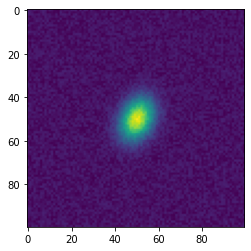

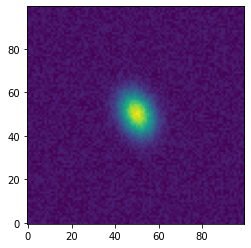

In [4]:
plt.imshow(cii158_blob.final)

fig = plt.figure()
fig.add_subplot(111, projection=cii158_blob.wcs)
plt.imshow(cii158_blob.final, origin='lower', cmap=plt.cm.viridis)


In [5]:
intensity = dict()
intensity['H200S0'] = 3.003e-05
intensity['H200S1'] = 3.143e-04
intensity['H200S2'] = 3.706e-04
intensity['H200S3'] = 1.060e-03
# Add a point for J=6 so that the fit is not overconstrained.
intensity['H200S4'] = 5.282e-04
intensity['H200S5'] = 5.795e-04
a = []
for i in intensity:
    m = Blob(amp=intensity[i],sigmax=10,sigmay=15,error=0.25, name=i,unit="erg cm-2 s-1 sr-1",pa=-25)
    m.set_FITS_template('pdrtpy/testdata/n22_cii_flux.fits')
    a.append(m)

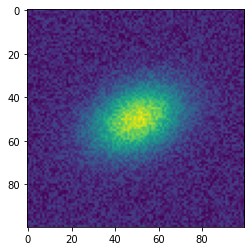

In [8]:
for j in a:
    plt.imshow(j.final)
    j.wcs.wcs.crpix=np.array([50,50])
    j.write(j._name+'_blob.fits',overwrite=True)

In [9]:
for j in intensity:
    outfile = f"{j:s}_test_data.fits"
    infile = f"{j:s}_blob.fits"
    Measurement.make_measurement(overwrite=True,datafile=infile,outfile=outfile,error="rms",rms=0.25*intensity[j],unit="erg cm-2 s-1 sr-1")

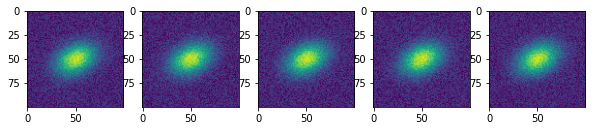

In [10]:
q = []
for j in intensity:
    infile=f"{j:s}_test_data.fits"
    m = Measurement.read(infile,identifier=j)
    q.append(m)
fig,ax = plt.subplots(1,5,figsize=(10,5))
i = 0
for j in ax:
    j.imshow(q[i])
    i = i+1

In [14]:
type(q[1])

pdrtpy.measurement.Measurement

In [17]:
from astropy.nddata.utils import Cutout2D
from astropy.coordinates import SkyCoord
qsize = np.array([35,25])*q[1].wcs.wcs.cdelt[0]*u.deg
print(qsize,type(qsize))
c = SkyCoord("00:47:53.7 -73:17:45.7",frame="icrs",unit=(u.hourangle, u.deg))

[-0.02770845 -0.01979175] deg <class 'astropy.units.quantity.Quantity'>


In [36]:
cut = Cutout2D(q[1],position=[50,50],size=[35,25],wcs=q[1].wcs,fill_value=np.nan)

In [39]:
cut.data

masked_array(
  data=[[9.89280186831048e-06, 7.10660133373397e-05,
         3.482786297393575e-05, 2.3126125631208248e-05,
         7.607585223818212e-05, 4.019496992076096e-05,
         9.13907887579394e-05, 3.09097972297298e-05,
         8.182757489018263e-05, 9.341605957138449e-05,
         7.083471427867299e-05, 9.843691479338265e-05,
         9.62827797135661e-05, 9.671944408129742e-05,
         6.378985248931445e-05, 7.89215495698528e-05,
         0.00011749885271387016, 9.984773844574156e-05,
         7.779714953679668e-05, 0.00010053600385426982,
         0.00011584863420416056, 9.951847946825077e-05,
         5.599126125152756e-05, 6.878437849758829e-05,
         8.515078785363556e-05],
        [7.253579471005933e-05, 2.8041766802523697e-05,
         6.256667638350333e-05, 6.251008172511341e-05,
         5.93096100312025e-05, 7.939226058869333e-05,
         4.3896339295636185e-05, 5.6982633820452914e-05,
         7.237437005503189e-05, 4.870815249643435e-05,
         0.0001211